# MLP Modeling - 7

with hugging face api

In [1]:
import os
from datetime import datetime as dt

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sentence_transformers import SentenceTransformer
# import optuna

2023-04-29 16:12:59.354904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 16:12:59.495014: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 16:13:00.292395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/loca

In [2]:
# model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

## load data

In [3]:
train_df = pd.read_csv("open/train.csv", index_col='ID')
test_df = pd.read_csv("open/test.csv", index_col='ID')
sample_submission_df = pd.read_csv("open/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((871393, 9), (159621, 8), (159621, 2))

In [4]:
book_dict = train_df[['Book-ID', 'Book-Title']].drop_duplicates(
    keep='first').values
book_list = np.unique(book_dict[:, 0])

In [5]:
test_book_dict = test_df[['Book-ID', 'Book-Title']].drop_duplicates(
    keep='first').values
test_book_list = np.unique(test_book_dict[:, 0])

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871393 entries, TRAIN_000000 to TRAIN_871392
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              871393 non-null  object 
 1   Book-ID              871393 non-null  object 
 2   Book-Rating          871393 non-null  int64  
 3   Age                  871393 non-null  float64
 4   Location             871393 non-null  object 
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  float64
 8   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 66.5+ MB


## preprocess data

In [7]:
train_users = train_df['User-ID'].unique()
train_books = train_df['Book-ID'].unique()

len(train_users), len(train_books)

(83256, 243441)

In [8]:
test_users = test_df['User-ID'].unique()
test_books = test_df['Book-ID'].unique()

len(test_users), len(test_books)

(21909, 62333)

In [9]:
len(set(train_users) | set(test_users)), len(set(train_books) | set(test_books))

(92101, 270056)

새로운 유저, 새로운 책이 분명 있음

In [10]:
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
ID,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


User feature
 * Age: int
 * Location: string

Book feature
 * Book-Title: string
 * Book-Author: string
 * Year-Of-Pulication: int
 * Publisher: string

특징의 분해 이전에 label 형태로도 해볼 수 있음

# Feature Selection

In [11]:
features = test_df.columns
features

Index(['User-ID', 'Book-ID', 'Age', 'Location', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher'],
      dtype='object')

In [12]:
continuous_features = ['Age', 'Year-Of-Publication']
categorical_features = ['Location', 'Book-Title', 'Book-Author', 'Publisher']

In [13]:
train_df['Location'] = train_df['Location'].str.replace(' ', '')
train_df['Location_country'] = train_df['Location'].apply(lambda x: x.split(',')[-1])
train_df['Location_city'] = train_df['Location'].apply(lambda x: x.split(',')[-2])
train_df.drop(columns='Location', inplace=True)
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,Road Taken,Rona Jaffe,2001.0,Mira,canada,newbrunswick
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,canada,newbrunswick
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,Mother Earth Father Sky,Sue Harrison,1991.0,Avon,canada,newbrunswick
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,canada,newbrunswick


In [14]:
test_df['Location'] = test_df['Location'].str.replace(' ', '')
test_df['Location_country'] = test_df['Location'].apply(lambda x: x.split(',')[-1])
test_df['Location_city'] = test_df['Location'].apply(lambda x: x.split(',')[-2])
test_df.drop(columns='Location', inplace=True)
test_df.head()

,User-ID,Book-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location_country,Location_city
ID,,,,,,,,,
TEST_000000,USER_00008,BOOK_047966,37.0,Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon,usa,ohio
TEST_000001,USER_00008,BOOK_119494,37.0,Midnight Voices,JOHN SAUL,2003.0,Ballantine Books,usa,ohio
TEST_000002,USER_00008,BOOK_151775,37.0,Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass,usa,ohio
TEST_000003,USER_00008,BOOK_176255,37.0,Bitter Harvest,Ann Rule,1999.0,Pocket,usa,ohio
TEST_000004,USER_00008,BOOK_187307,37.0,Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books,usa,ohio


# Embedding with huggingface api

In [15]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")#, from_tf=True)

In [16]:
# book_title_encoded = np.zeros(shape=(book_dict.shape[0], 384), dtype='float32')
# book_title_encoded.shape

In [17]:
# for i, row in tqdm(enumerate(book_dict[:, 1]), total=book_dict.shape[0]):
#     book_title_encoded[i, :] = model.encode(row)

In [18]:
# book_dict.shape, book_title_encoded.shape

In [19]:
# book_infos = np.concatenate([book_dict, book_title_encoded], axis=1)
# np.save('meta/book_infos_23-04-30.npy', book_infos, allow_pickle=True)

In [20]:
book_infos = np.load('meta/book_infos_23-04-30.npy', allow_pickle=True)
book_infos

array([['BOOK_044368', 'Road Taken', 0.294543981552124, ...,
        -0.14742030203342438, -0.3801998794078827, -0.0736732929944992],
       ['BOOK_081205', 'Macbeth (New Penguin Shakespeare)',
        0.05064263194799423, ..., -0.04678504168987274,
        0.33441928029060364, -0.21163484454154968],
       ['BOOK_086781', 'Waverley (Penguin English Library)',
        -0.41163453459739685, ..., -0.1508823037147522,
        0.711206316947937, 0.36754968762397766],
       ...,
       ['BOOK_265220',
        "He's My Brother: Former Racial Foes Offer Strategy for Reconciliation",
        -0.21202334761619568, ..., 0.1758103221654892,
        0.13197553157806396, -0.3028498888015747],
       ['BOOK_266941',
        'Creme De Colorado Cookbook (Celebrating Twenty Five Years of Culinary Artistry)',
        -0.09288963675498962, ..., -0.09125104546546936,
        0.30533093214035034, -0.1250997930765152],
       ['BOOK_130798',
        'The Coffin Quilt: The Feud between the Hatfields and the

In [21]:
book_dict[:, 1].shape

(243441,)

In [22]:
# test_book_title_encoded = np.zeros(shape=(test_book_dict.shape[0], 384), dtype='float32')
# for i, row in tqdm(enumerate(test_book_dict[:, 1]), total=test_book_dict.shape[0]):
#     test_book_title_encoded[i, :] = model.encode(row)

In [23]:
# test_book_infos = np.concatenate([test_book_dict, test_book_title_encoded], axis=1)
# np.save('meta/test_book_infos_23-04-30.npy', test_book_infos, allow_pickle=True)

In [24]:
test_book_infos = np.load('meta/test_book_infos_23-04-30.npy', allow_pickle=True)
test_book_infos

array([['BOOK_047966', 'Birds of Prey: A Novel of Suspense',
        0.10833008587360382, ..., 0.13077646493911743,
        -0.4036148190498352, 0.18236258625984192],
       ['BOOK_119494', 'Midnight Voices', 0.031112201511859894, ...,
        0.28217703104019165, -0.594933807849884, -0.544209361076355],
       ['BOOK_151775',
        'Breaking Free : A Prescription for Personal and Organizational Change (Jossey-Bass Business &amp; Management Series)',
        -0.07000124454498291, ..., -0.5125600695610046,
        0.24708081781864166, 0.05571218580007553],
       ...,
       ['BOOK_156256',
        'Sierra: Notes and Images from the Range of Light',
        -0.20738327503204346, ..., 0.06074671819806099,
        -0.34741511940956116, 0.21215474605560303],
       ['BOOK_199754',
        "From 60 Yards In : How to Master Golf's Short Game",
        0.518082320690155, ..., -0.1259591281414032, 0.16431060433387756,
        0.2763310968875885],
       ['BOOK_237054', 'Avalanche Safety: For

In [25]:
book_titles = np.zeros(shape=(train_df.shape[0], 384), dtype='float32')
test_book_titles = np.zeros(shape=(test_df.shape[0], 384), dtype='float32')

In [26]:
book_infos[:, 0]

array(['BOOK_044368', 'BOOK_081205', 'BOOK_086781', ..., 'BOOK_265220',
       'BOOK_266941', 'BOOK_130798'], dtype=object)

In [27]:
book_infos_dict = {k: v for k, v in zip(book_list, book_infos[:, 2:])}
test_book_infos_dict = {k: v for k, v in zip(test_book_list, test_book_infos[:, 2:])}

In [28]:
for i, row in tqdm(enumerate(train_df['Book-ID']), total=train_df.shape[0]):#book_infos
    book_titles[i] = book_infos_dict[row]

100%|██████████| 871393/871393 [00:09<00:00, 87676.62it/s]


In [29]:
for i, row in tqdm(enumerate(test_df['Book-ID']), total=test_df.shape[0]):#book_infos
    test_book_titles[i] = test_book_infos_dict[row]

100%|██████████| 159621/159621 [00:01<00:00, 90041.30it/s]


- https://huggingface.co/blog/getting-started-with-embeddings
- https://anpigon.tistory.com/387
- https://huggingface.co/docs/transformers/preprocessing

# encoding

for location_country, publisher

In [30]:
# from sklearn.preprocessing import OneHotEncoder

In [31]:
# cont_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
# train_country_array = cont_encoder.fit_transform(train_df[['Location_country']]).toarray()
# test_country_array = cont_encoder.transform(test_df[['Location_country']]).toarray()

In [32]:
# pub_encoder = OneHotEncoder(handle_unknown='ignore', dtype='bool')
# train_publisher_array = pub_encoder.fit_transform(train_df[['Publisher']]).toarray()
# test_publisher_array = pub_encoder.transform(train_df[['Publisher']]).toarray()

# scaling

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
train_cont_array = scaler.fit_transform(train_df[continuous_features])
test_cont_array = scaler.transform(test_df[continuous_features])

# merge prcessed data

In [35]:
train_cont_array.shape, book_titles.shape#train_country_array.shape, train_publisher_array.shape

((871393, 2), (871393, 384))

In [36]:
# train_x = {
#     'input_continuous': train_cont_array,
#     'input_country': train_country_array,
# }

# test_x = {
#     'input_continuous': test_cont_array,
#     'input_country': test_country_array,
# }

train_x = [train_cont_array, book_titles]#train_country_array, train_publisher_array]
test_x = [test_cont_array, test_book_titles]#test_country_array, test_publisher_array]

In [37]:
# train_x = np.concatenate([train_cont_array, train_df[['Location_country']].values], axis=1) #train_publisher_array
# test_x = np.concatenate([test_cont_array, test_df[['Location_country']].values], axis=1) #test_publisher_array

# train_x.shape, test_x.shape

In [38]:
train_y = train_df['Book-Rating'].values
train_y.shape

(871393,)

In [39]:
# train_array = np.concatenate([train_cont_array, train_country_array, train_publisher_array], axis=1)
# test_array = np.concatenate([test_cont_array, test_country_array, test_publisher_array], axis=1)

# model

In [40]:
alpha = 0.001

In [41]:
book_titles.shape[1]

384

In [42]:
def build_custom_model(input_dims, alpha):
    # define input tensor
    input_continuous = tf.keras.Input(shape=input_dims[0], dtype=tf.float32)
    input_title = tf.keras.Input(shape=input_dims[1], dtype=tf.float32)
    # input_country = tf.keras.Input(shape=input_dims[1], dtype='bool')
    # input_publisher = tf.keras.Input(shape=input_dims[2], dtype='bool')

    # # embedding layer
    # embed_country_layer = tf.keras.layers.Embedding(
    #     train_country_array.shape[1], 10)(input_country)

    # # rnn layer
    # country_layer = tf.keras.layers.SimpleRNN(
    #     10, return_sequences=False, dtype=np.float32)(embed_country_layer)

    # # embedding layer
    # embed_publisher_layer = tf.keras.layers.Embedding(
    #     train_country_array.shape[1], 10)(input_publisher)

    # # rnn layer
    # publisher_layer = tf.keras.layers.SimpleRNN(
    #     10, return_sequences=False, dtype=np.float32)(embed_publisher_layer)

    # concatenate
    x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, input_title])#country_layer, publisher_layer])
    # # concatenate
    # x = tf.keras.layers.Concatenate(axis=-1)([input_continuous, input_country])

    # hidden layer
    x = tf.keras.layers.Dense(
        64, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # hidden layer
    x = tf.keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)

    # output layer
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model([input_continuous, input_title], x)#input_country, input_publisher], x)

    return model

In [43]:
learning_rate = 0.001
batch_size = 1000
epochs = 100
alpha = 0.005

In [44]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = build_custom_model(input_dims=[
        train_cont_array.shape[1],
        book_titles.shape[1]
        # train_country_array.shape[1], 
        # train_publisher_array.shape[1]
    ], alpha=alpha)

    # define optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # model compile
    model.compile(optimizer=optimizer, loss='mse', metrics='mse')

2023-04-29 16:13:31.095585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38220 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 386)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           24768       ['concatenate[0][0]']        

In [46]:
history = model.fit(train_x, train_y, validation_split=.1, epochs=epochs, batch_size=batch_size)

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-04-29 16:13:37.428838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


785/785 [==============================] - 9s 6ms/step - loss: 15.2716 - mse: 14.8975 - val_loss: 14.9335 - val_mse: 14.7280
Epoch 2/100
785/785 [==============================] - 3s 4ms/step - loss: 14.9234 - mse: 14.7685 - val_loss: 14.8288 - val_mse: 14.7111
Epoch 3/100
785/785 [==============================] - 3s 4ms/step - loss: 14.8493 - mse: 14.7471 - val_loss: 14.7933 - val_mse: 14.7073
Epoch 4/100
785/785 [==============================] - 3s 4ms/step - loss: 14.8167 - mse: 14.7367 - val_loss: 14.7526 - val_mse: 14.6802
Epoch 5/100
785/785 [==============================] - 3s 4ms/step - loss: 14.7999 - mse: 14.7307 - val_loss: 14.7582 - val_mse: 14.6935
Epoch 6/100
785/785 [==============================] - 3s 4ms/step - loss: 14.7887 - mse: 14.7247 - val_loss: 14.7463 - val_mse: 14.6865
Epoch 7/100
785/785 [==============================] - 3s 4ms/step - loss: 14.7812 - mse: 14.7207 - val_loss: 14.7493 - val_mse: 14.6916
Epoch 8/100
785/785 [==============================] 

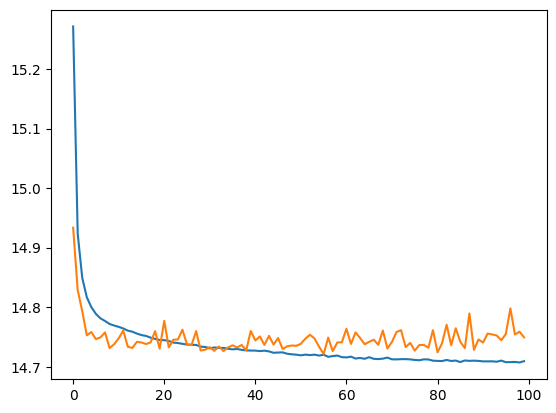

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [50]:
train_pred = model.predict(train_x)
train_pred

27232/27232 [==============================] - 53s 2ms/step


array([[2.6771321],
       [2.7879457],
       [2.5461497],
       ...,
       [2.9343586],
       [2.7446923],
       [2.7909765]], dtype=float32)

In [51]:
train_pred.shape

(871393, 1)

In [52]:
test_pred = model.predict(test_x)
test_pred

4989/4989 [==============================] - 10s 2ms/step


array([[3.0521374],
       [2.9082785],
       [2.5291767],
       ...,
       [3.5296183],
       [3.6354275],
       [3.7303672]], dtype=float32)

In [53]:
from sklearn.metrics import mean_squared_error

In [54]:
rmse = mean_squared_error(train_y, train_pred, squared=False)
rmse

3.8194152334861986

In [55]:
sample_submission_df = pd.read_csv("open/sample_submission.csv")
sample_submission_df

,ID,Book-Rating
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0
...,...,...
159616,TEST_159616,0
159617,TEST_159617,0
159618,TEST_159618,0
159619,TEST_159619,0


In [56]:
mname = 'custom_dl'

In [58]:
def make_report(template, test_pred, mname):
    template['Book-Rating'] = test_pred
    now = dt.strftime(dt.now(), '%y-%m-%d')
    template.to_csv(f'results/{mname}-{now}.csv', index=False)
    
make_report(sample_submission_df, test_pred, mname)

test_rmse = 3.8036542165822924